In [1]:
from tqdm.notebook import tqdm

import pprint
import bs4

from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.output_parsers import JsonOutputParser
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_ollama import OllamaEmbeddings
from langchain_ollama import ChatOllama
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import GraphRecursionError
from langchain.prompts import PromptTemplate

from typing import List
from typing_extensions import TypedDict

from abc import ABC, abstractmethod
from operator import itemgetter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# model_name="gemma2:2b"
model_name = "qwen2:0.5b"
embd = OllamaEmbeddings(model=model_name)
llm = ChatOllama(model=model_name, temperature=0)

## .. 문서 - vectorstore

### ... web

In [5]:
def load_document_web(web_path):
    loader = WebBaseLoader(
        web_paths=web_path,
        bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                "div",
                # attrs={"class": ["mw-content-ltr mw-parser-output"]},
                attrs={"class": ["newsct_article _article_body",
                             "media_end_head_title"]},
            )
        ),
    )
    docs = loader.load()
    print(f"문서의 수: {len(docs)}")
    return docs

In [6]:
# web_path = "https://n.news.naver.com/mnews/hotissue/article/001/0014896674?type=series&cid=1087298"
web_path = (
    "https://n.news.naver.com/mnews/hotissue/article/001/0014896674?type=series&cid=1087298",
    "https://n.news.naver.com/mnews/article/366/0001014658",
    "https://n.news.naver.com/mnews/article/021/0002657064",
    "https://n.news.naver.com/mnews/article/119/0002868335",    
    "https://n.news.naver.com/mnews/article/031/0000866996",
    "https://n.news.naver.com/mnews/article/277/0005467269",
    "https://n.news.naver.com/mnews/article/014/0005236428",
    "https://n.news.naver.com/mnews/hotissue/article/081/0003477228?type=series&cid=1064685",
    "https://n.news.naver.com/mnews/article/662/0000051263",
    "https://n.news.naver.com/mnews/article/030/0003237005",
)
docs = load_document_web(web_path)

문서의 수: 10


In [7]:
# from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initialize the text splitter with the chunk size and overlap settings
text_splitter = RecursiveCharacterTextSplitter(chunk_size=4000, chunk_overlap=100)

# Split the document into chunks
# documents = text_splitter.split_text(docs)
documents = text_splitter.split_documents(docs)

In [8]:
for i, d in enumerate(documents):
    print(f"{i}: {d.page_content[:100].replace('\n',' ')}\n")

0: [사이테크+] '사건의 지평선 망원경' 사상 최고 해상도로 M87* 블랙홀 관측   국제 연구팀 "EHT에 0.87㎜ 파장 첫 적용…블랙홀 관측 사상 최고 해상도" (서울=연합뉴스

1: ‘카툭튀’ 없는 렌즈부터 성격 가진 로봇까지… 애플이 내놓을 신기술은   아이폰16 페이스 ID 카메라에 ‘메타렌즈’ 적용설스스로 주행하며 이용자 돕는 가정용 로봇도 개발 중’시리

2: SK하이닉스, ‘10나노급 6세대 D램’ 세계 첫 개발   속도 11%· 전력효율 9% 향상    SK하이닉스가 현존하는 D램 중 가장 미세화된 ‘10나노(㎚·1나노는 10억 분의

3: KISA, AI Security Day 세미나…사이버 위협 대응 방안 논의   5일 용산 로얄파크컨벤션서 개최    ‘2024 AI Security Day’ 인공지능 보안 세미나 

4: 이정헌 넥슨 대표 "2027년까지 매출 7500억엔 달성 목표"   "종적 성장과 횡적 확장 전략 통해 IP 프랜차이즈 다수 확보"국내 게임업계에서 독보적인 1위 자리를 굳힌 넥슨

5: 아이폰16 출시일 맞춰 3단 폴더블폰 펼치는 中 화웨이   신제품 혈투…9월10일 잇달아 공개화웨이가 애플의 새로운 아이폰 시리즈 출시일에 맞춰 자사 신제품을 선보이기로 했다. 시

6: 삼성SDS "GPU 비중 높인 AI 클라우드로 발전…내달 美 진출"   리얼 서밋 2024 개최SCP, 패브릭스·브리티코파일럿 강조엔비디아·델·MS·워크데이와 협력 강화내달 패브릭

7: ‘금 나와라, 뚝딱!’ 현실로?…‘거대한 금덩어리’ 생성 과정 최초로 밝혀졌다[핵잼 사이언스]   			[서울신문 나우뉴스]    자료사진 123rf.com근대 과학이 발달하기 이

8: “바위 넘고 계단 오르는 ‘휠체어’ 가능할까”…세계 최초 ‘말랑한 바퀴’ 개발   한국기계연구원, 표면장력 원리 모사한 ‘모핑 휠’ 개발장애물에 따라 실시간으로 바퀴 모양 변화이동

9: 中 반도체 자립 전략에 장비 산업 '쑥쑥'   			중국이 미국 제재에 맞서 반도체 자립을 추

### ... vectorstore

In [3]:
faiss_path = f"data/{model_name.replace(':','-').replace(".",'')}_naver-news"
faiss_path

'data/qwen2-05b_naver-news'

#### save

In [77]:
vectorstore = None
for d in tqdm(documents):
    if vectorstore:
        vectorstore.add_documents([d])
    else:
        vectorstore = FAISS.from_documents(
            documents=[d], 
            embedding=embd
        )

vectorstore.save_local(faiss_path)

  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
for d in tqdm(documents):
    vectorstore.add_documents([d])

vectorstore.save_local(faiss_path)

  0%|          | 0/6 [00:00<?, ?it/s]

#### load

In [4]:
vectorstore = FAISS.load_local(
    faiss_path,
    embeddings=embd,
    allow_dangerous_deserialization=True
)

## .. Retriever

### ... query

In [5]:
# query = "사상 최고 해상도로 관측한 블랙홀의 이름은 무엇입니까?"

# query = "SK하이닉스는 어떤 D램을 개발하였습니까?"

# query = "애플은 어떤 기술을 개발하고 있나요?"
# query = "애플이 개발하고 있는 신기술은 무엇입니까?"
# query = "애플의 메타렌즈는 무엇입니까?"
query = "애플이 '카툭튀' 현상을 완화해주는 기술은 무엇인가요?"

### ... retriever

In [13]:
retriever = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": 10,
        "fetch_k": 10,
        "lambda_mult": 0.7
    }
)

In [6]:
retriever = vectorstore.as_retriever(
    search_type="similarity",  # use a basic similarity search
    search_kwargs={
        "k": 10,  # retrieve top 10 documents
        "fetch_k": 10  # number of documents to fetch before filtering
    }
)

In [7]:
documents = retriever.invoke(query)

### ... score check

In [7]:
results = vectorstore.similarity_search_with_score(
    query=query,
    k=vectorstore.index.ntotal
)

scores = []

for doc, score in results:
    print(f"Score: {score:.3f}\n{doc.page_content[:50].replace('\n',' ')}\n")
    scores.append(score)

# scores

Score: 0.220
SK하이닉스, ‘10나노급 6세대 D램’ 세계 첫 개발   속도 11%· 전력효율 9% 향

Score: 0.285
KISA, AI Security Day 세미나…사이버 위협 대응 방안 논의   5일 용산 

Score: 0.312
아이폰16 출시일 맞춰 3단 폴더블폰 펼치는 中 화웨이   신제품 혈투…9월10일 잇달아 

Score: 0.328
‘카툭튀’ 없는 렌즈부터 성격 가진 로봇까지… 애플이 내놓을 신기술은   아이폰16 페이스

Score: 0.332
“바위 넘고 계단 오르는 말랑한 바퀴”…세계 최초 개발   한국기계연구원, 표면장력 원리 

Score: 0.352
이정헌 넥슨 대표 "2027년까지 매출 7500억엔 달성 목표"   "종적 성장과 횡적 확

Score: 0.355
‘금 나와라, 뚝딱!’ 현실로?…‘거대한 금덩어리’ 생성 과정 최초로 밝혀졌다[핵잼 사이언

Score: 0.357
中 반도체 자립 전략에 장비 산업 '쑥쑥'   			중국이 미국 제재에 맞서 반도체 자립을

Score: 0.562
삼성SDS "GPU 비중 높인 AI 클라우드로 발전…내달 美 진출"   리얼 서밋 2024

Score: 0.653
[사이테크+] '사건의 지평선 망원경' 사상 최고 해상도로 M87* 블랙홀 관측   국제 



### ... documents check

In [8]:
for i, d in enumerate(documents):
    print(f"{i}: {d.page_content[:50].replace('\n', ' ')}\n")

0: SK하이닉스, ‘10나노급 6세대 D램’ 세계 첫 개발   속도 11%· 전력효율 9% 향

1: KISA, AI Security Day 세미나…사이버 위협 대응 방안 논의   5일 용산 

2: 아이폰16 출시일 맞춰 3단 폴더블폰 펼치는 中 화웨이   신제품 혈투…9월10일 잇달아 

3: ‘카툭튀’ 없는 렌즈부터 성격 가진 로봇까지… 애플이 내놓을 신기술은   아이폰16 페이스

4: “바위 넘고 계단 오르는 말랑한 바퀴”…세계 최초 개발   한국기계연구원, 표면장력 원리 

5: 이정헌 넥슨 대표 "2027년까지 매출 7500억엔 달성 목표"   "종적 성장과 횡적 확

6: ‘금 나와라, 뚝딱!’ 현실로?…‘거대한 금덩어리’ 생성 과정 최초로 밝혀졌다[핵잼 사이언

7: 中 반도체 자립 전략에 장비 산업 '쑥쑥'   			중국이 미국 제재에 맞서 반도체 자립을

8: 삼성SDS "GPU 비중 높인 AI 클라우드로 발전…내달 美 진출"   리얼 서밋 2024

9: [사이테크+] '사건의 지평선 망원경' 사상 최고 해상도로 M87* 블랙홀 관측   국제 



## .. LLMs

In [9]:
temperature = 0.36

### ... Triplet

In [10]:
template_triplet = """후보 답변이 주어졌을 때, 후보 답변으로부터 질문을 조건으로 하여 지식 그래프(KG)를 추출하세요. 
    추출된 지식 그래프는 ("주어", "서술어", "목적어") 형식의 삼중항(triplet)으로 표현하며, 각 삼중항은 한 줄에 작성하세요. 
    위 작업 내용을 다시 읽어주세요: 후보 답변이 주어졌을 때, 후보 답변으로부터 질문을 조건으로 하여 지식 그래프(KG)를 추출하세요. 
    추출된 지식 그래프는 ("주어", "서술어", "목적어") 형식의 삼중항(triplet)으로 표현하며, 각 삼중항은 한 줄에 작성하세요. 

    위 작업의 예시는 다음과 같습니다.

    ### 후보 답변:
    KISA는 이번 세미나에서 ‘AI가 만든 사이버위협, AI가 막는 사이버위협’이라는 주제로 AI 기술의 순기능과 역기능을 조명한다. AI와 인간이 상생할 수 있는 안전한 환경 조성을 위해 다양한 세션을 제공할 예정이다.

    ### 지식 그래프:
    ("KISA", "조명", "AI 기술의 순기능과 역기능")
    ("KISA", "제공", "다양한 세션")
    ("이번 세미나", "주제", "‘AI가 만든 사이버위협, AI가 막는 사이버위협’")
    
    ### 후보 답변:
    세종대왕은 1397년 4월 10일(음력)에 한성부 북부 준수방(지금의 서울특별시 종로구 통인동)에서 태종과 원경왕후의 셋째 아들로 태어났습니다. 
    세종대왕은 조선의 제4대 왕으로, 1418년에 왕위에 올라 32년간 재위하며 조선의 정치, 경제, 문화 등 모든 분야에서 큰 발전을 이루었습니다.

    ### 지식 그래프:
    ("세종대왕", "출생", "1397년 4월 10일(음력)")
    ("세종대왕", "출생지", "한성부 북부 준수방(지금의 서울특별시 종로구 통인동)")
    ("세종대왕", "부모", "태종과 원경왕후")
    ("세종대왕", "왕위에 오름", "1418년")
    ("세종대왕", "재위 기간", "32년")
    
     \n\n\n

     이제 아래에 주어진 질문과 후보 답변으로 지식 그래프를 추출해주세요.

     ### 후보 답변:
     {candidate}

     ### 지식 그래프:

     이 작업은 추출 작업이므로, 후보 답변의 내용이 사실인지 여부는 고려하지 말고, 단순히 해당 내용에서 삼중항을 추출하는 데 집중하세요.
     설명이나 개인적인 추론을 덧붙이지 마세요.
     """

In [11]:
prompt = PromptTemplate(
    template=template_triplet,
    input_variables=["candidate"],
)

model_name_triplet = "gemma2:2b"
llm = ChatOllama(model=model_name_triplet, temperature=0.1)
rag_triplet = prompt | llm | StrOutputParser()

In [27]:
for i, d in enumerate(documents):
    gen_triplet = rag_triplet.invoke({"candidate": d.page_content})
    print(f"{i:02}:\n{gen_triplet}\n")

00:
```
("SK하이닉스", "개발", "10나노급 6세대 D램")
("SK하이닉스", "속도", "11% 빠르고 전력효율은 9% 이상 개선된다")
("SK하이닉스", "전력효율", "9% 이상 개선된다")
("SK하이닉스", "D램", "6세대 D램")
("SK하이닉스", "DDR5", "고성능 데이터센터 등에 쓰인다")
("SK하이닉스", "전력비용", "최대 30%까지 줄일 수 있을 것으로 기대하고 있다")
("SK하이닉스", "6세대 D램", "클라우드 서비스를 운영하는 글로벌 고객들이 SK하이닉스 6세대 D램을 데이터센터에 적용하면 전력 비용을 이전보다 최대 30%까지 줄일 수 있을 것으로 기대하고 있다")
("SK하이닉스", "HBM4E", "향후 7세대 고대역폭 메모리(HBM)인 HBM4E 등에 6세대 기술을 적용한다는 계획이다")
``` 




01:
```
("KISA", "세미나", "AI Security Day")
("KISA", "주제", "AI가 만든 사이버위협, AI가 막는 사이버위협")
("KISA", "방안 논의", "사이버 위협 대응 방안")
```

02:
```
("화웨이", "신제품 출시", "3단 폴더블폰")
("화웨이", "공개", "9월10일 오후 2시30분")
("화웨이", "출시 일정", "애플 아이폰16 공개 당일")
("화웨이", "제품 출시", "삼성전자를 밀어냈다")
("화웨이", "중국 시장 점유율", "13%")
("애플", "아이폰", "9월 캘리포니아 쿠퍼티노 본사에서 가을 신제품 출시 콘퍼런스 개최")
("애플", "중국 시장 점유율", "14%")
("애플", "중국 시장 출하량", "약 970만대")
``` 




03:
```
("한국기계연구원", "개발", "모핑 휠")
("한국기계연구원", "실험", "투 휠 기반 휠체어")
("한국기계연구원", "표면장력 원리 모사", "모핑 휠")
("한국기계연구원", "장애물 극복", "바위와 계단 오르내리는 것")
``` 


04:
```


In [19]:
triplets = """00:
```
("SK하이닉스", "개발", "10나노급 6세대 D램")
("SK하이닉스", "속도", "11% 빠르고 전력효율은 9% 이상 개선된다")
("SK하이닉스", "전력효율", "9% 이상 개선된다")
("SK하이닉스", "D램", "6세대 D램")
("SK하이닉스", "DDR5", "고성능 데이터센터 등에 쓰인다")
("SK하이닉스", "전력비용", "최대 30%까지 줄일 수 있을 것으로 기대하고 있다")
("SK하이닉스", "6세대 D램", "클라우드 서비스를 운영하는 글로벌 고객들이 SK하이닉스 6세대 D램을 데이터센터에 적용하면 전력 비용을 이전보다 최대 30%까지 줄일 수 있을 것으로 기대하고 있다")
("SK하이닉스", "HBM4E", "향후 7세대 고대역폭 메모리(HBM)인 HBM4E 등에 6세대 기술을 적용한다는 계획이다")
``` 




00:
```
("KISA", "세미나", "AI Security Day")
("KISA", "주제", "AI가 만든 사이버위협, AI가 막는 사이버위협")
("KISA", "방안 논의", "사이버 위협 대응 방안")
```

00:
```
("화웨이", "신제품 출시", "3단 폴더블폰")
("화웨이", "공개", "9월10일 오후 2시30분")
("화웨이", "출시 일정", "애플 아이폰16 공개 당일")
("화웨이", "제품 출시", "삼성전자를 밀어냈다")
("화웨이", "중국 시장 점유율", "13%")
("애플", "아이폰", "9월 캘리포니아 쿠퍼티노 본사에서 가을 신제품 출시 콘퍼런스 개최")
("애플", "중국 시장 점유율", "14%")
("애플", "중국 시장 출하량", "약 970만대")
``` 




00:
```
("한국기계연구원", "개발", "모핑 휠")
("한국기계연구원", "실험", "투 휠 기반 휠체어")
("한국기계연구원", "표면장력 원리 모사", "모핑 휠")
("한국기계연구원", "장애물 극복", "바위와 계단 오르내리는 것")
``` 


00:
```
("애플", "메타렌즈 적용", "아이폰16 페이스 ID 카메라")
("애플", "AI 로봇 개발", "가정용 AI 로봇")
("애플", "성격 가진 로봇", "인공지능 (AI) 로봇")
("애플 링", "AI 비서 시리 연결", "특허")
("애플 링", "마이크와 스피커 적용", "말 인식 및 대답")
("애플 링", "독립적인 기기", "머리를 흔드는 것만으로 전화 수락/거절")
``` 




00:
```
("이정헌 넥슨 대표", "목적어", "2027년까지 매출 7500억엔 달성 목표")
("이정헌 넥슨 대표", "목적어", "영업이익 2500억엔(약 2조3000억원) 달성")
("넥슨", "전략", "종적 성장과 차세대 IP 육성을 통한 '횡적 확장'")
("넥슨", "목표", "7조 클럽 가입")
("넥슨", "전략", "라이브 오퍼레이션")
("넥슨", "IP", "다양한 신규 IP 창출")
``` 




00:
```
("연금술", "유행", "비금속을 인공적 수단을 통해 금 등의 귀금속으로 바꾸는")
("석영", "압전 전압", "지진이 석영에 가하는 '압전 전압'")
("석영", "압력", "지진이 석영에 가하는 '압전 전압'")
("금", "용해된 금", "액체에서 금이 침착(밑으로 가라앉아 들러붙음)")
("금", "형성", "지진이 석영에 가하는 '압전 전압'")
("금", "형성", "지진과 압력")
("금", "형성", "석영 광맥의 틈으로 침투한 뒤 지진이 일으키는 전기장과 만났을 때 금이 형성된다.")
("금", "형성", "대체로 큰 금덩어리가 지진 중 조산운동으로 형성되는 퇴적층에서 발견된다.")
("석영", "압전 광물", "석영은 압축되거나 늘리는 등 물리적인 스트레스를 받았을 때 전기장을 발생시키는 압전 광물이기도 하다.")
``` 




00:
```
("중국 반도체 장비 성장", "미국의 대중국 반도체 제재 때문")
("미국은 중국 반도체 성장을 견제하기 위해 자국 반도체 장비사들의 수출 제재뿐 아니라 동맹국에도 압박을 가하고 있다.", "동맹국 기업에 해외직접제품규칙(FDPR)을 적용하는 방식으로 제한을 가한다.")
("중국 반도체 장비 성장은 미국의 대중국 반도체 제재 때문이다", "미국은 중국 반도체 성장을 견제하기 위해 자국 반도체 장비사들의 수출 제재뿐 아니라 동맹국에도 압박을 가하고 있다.")
("나우라는 25억3200만 위안(약 4768억원)을 투자해 가장 규모가 컸다.", "중국 반도체 장비사 고객사는 자국 기업이 대부분이지만 내수 시장 규모는 더 커질 전망이다.")
``` 




00:
```
("삼성SDS", "GPU 비중 높인 AI 클라우드로 발전", "내달 美 진출")
("삼성SDS", "생성형 AI 서비스 활용", "패브릭스(FabriX)")
("삼성SDS", "생성형 AI 기반 협업솔루션", "브리티 코파일럿")
("삼성SDS", "내달 중 미국 시장에 패브릭스 출시", "MS 애저")
("삼성SDS", "퍼스널 에이전트 기능", "브리티 코파일럿")
("삼성SDS", "한국어 인식률", "언어 장벽 없음")
("삼성SDS", "한국 기업의 협력", "베트남 언어 추가")
``` 


00:
## 지식 그래프:

* **망원경:** ETH (0.87mm 파장), ALMA, APEX, IRAM 30m, NOEMA, GreenLanded 망원경
* **관측 목적:** M87 은하 중앙 블랙홀(M87*) 해상도 높은 관측
* **해상도:** 19 마이크로아크초 (예비 실험)
* **목표 해상도:** 13 마이크로아크초 (전체 ETH 활용 가능성)




""".split("00:\n")

In [20]:
gen_triplet_query = rag_triplet.invoke({"candidate": query})
print(gen_triplet_query)

```
("애플", "카툭튀 현상 완화 기술", "무엇인가요?")
``` 



### ... 문서 평가

In [12]:
template_retrieval = """당신은 사용자의 질문과 관련된 참고문서를 평가하는 일을 합니다.
    참고문서의 주어-서술어-목적어로 작성되어 있습니다.
    참고문서에 사용자의 질문의 주어와 참고문서의 주어가 같고 관련된 키워드가 있다면, '예' 라고 평가해주세요.
    참고문서에 사용자의 질문의 주어와 참고문서의 주어가 다르거나 관련된 키워드가 없다면 '아니오' 라고 평가해주세요.
    특히 참고문서의 주어와 질문의 주어가 맞는지 주목해주세요.
    \n\n\n
    참고문서: \n\n {document} \n\n
    사용자의 질문: {question} \n\n
    목표는 상관없는 문서를 거르는 것입니다. \n
    JSON 형식으로 'flag' 키에 '예', '아니오' 2가지 답을 주세요. 설명은 필요없습니다"""

In [13]:
### Retrieval Grader
prompt = PromptTemplate(
    template=template_retrieval,
    input_variables=["question", "document"],
)

# LLM
llm = ChatOllama(
    # model=model_name,
    model="gemma2:2b",
    format="json",
    temperature=temperature
    # temperature=0.3
)

retrieval_grader = prompt | llm | JsonOutputParser()

In [132]:
gen_grade = retrieval_grader.invoke({"question": query, "document": triplets[4]})
print(gen_grade)

{'flag': '아니오'}


In [131]:
gen_grade = retrieval_grader.invoke({"question": query, "document": triplets[5]})
print(gen_grade)

{'flag': '예'}


In [125]:
for i in range(3):
    print(f"{i}:")
    gen_grade = retrieval_grader.invoke({"question": query, "document": triplets[4]})
    print(gen_grade)
    gen_grade = retrieval_grader.invoke({"question": query, "document": triplets[5]})
    print(gen_grade)
    print()

0:
{'flag': '아니오'}
{'flag': '예'}

1:
{'flag': '아니오'}
{'flag': '예'}

2:
{'flag': '아니오'}
{'flag': '예'}



### ... 답변 생성

In [14]:
template_generator = """당신은 사용자의 질문에 답하는 일을 합니다.
    참고문서와 키워드 요약문을 사용하여 질문에 답해주세요. 
    키워드 요약문은 주어, 서술어, 목적어 형태로 구성되어 있습니다.
    최대 3문장으로 간단하게 답해주세요. 
    만약 당신이 답을 모른다면, 간단히 모른다고 답해주세요.
    \n\n\n
    사용자의 질문는 여기에 있습니다: {question} \n
    참고문서는 여기에 있습니다: {context} \n
    키워드 요약문은 여기에 있습니다: {keyword} \n
    \n\n\n
    답:"""

In [15]:
### Generate

prompt = PromptTemplate(
    template=template_generator,
    input_variables=["context", "question", "keyword"],
)

llm = ChatOllama(
    model="gemma2:2b",
    # temperature=0.1
    temperature=temperature
)
rag_chain = prompt | llm | StrOutputParser()

In [135]:
for i in range(1):
    generation = rag_chain.invoke({
        "context": documents[5],
        "keyword": triplets[5],
        "question": query})
    print(i, generation)

0 아이폰16 페이스 ID 카메라에 메타렌즈를 적용하여 '카툭튀' 현상을 완화하는 기술입니다. 애플은 성격 가진 AI 로봇 개발 중이며, 이로 인해 사용자의 필요에 맞는 서비스를 제공할 수 있도록 도와줄 것으로 예상됩니다.  애플 링에 마이크와 스피커를 적용하여 말 인식 및 대답 기술을 구현하는 데 활용될 예정입니다. 



### ... 문서에 기반한 답변인가

In [16]:
template_hallucination = """당신은 사실에 기반된 답변인지 확인하는 일을 합니다. \n 
    여기에 사실이 있습니다:
    \n ------- \n
    {documents} 
    \n ------- \n
    여기에 답변이 있습니다: {generation}
    사실에 기반한 답변이면, '예' 라고 평가해주세요. \n
    사실에 기반한 답변이 아니면 '아니오' 라고 평가해주세요. \n
    JSON 형식으로 'flag' 키에 '예', '아니오' 평가를 해주세요. \n
    설명은 필요없습니다."""

In [17]:
### Hallucination Grader

# Prompt
prompt = PromptTemplate(
    template=template_hallucination,
    input_variables=["generation", "documents"],
)

# LLM
llm = ChatOllama(
    model=model_name,
    format="json",
    temperature=temperature
)
hallucination_grader = prompt | llm | JsonOutputParser()

In [142]:
hallucination_grader.invoke({
    "documents": documents[5].page_content,
    "generation": generation
})

{'flag': '예'}

### ... 질문에 적절한 답변인가

In [18]:
template_verification = """당신은 답변이 질문과 관련된 내용이 있는지 평가하는 일을 합니다. \n\n
    여기에 사용자의 질문이 있습니다: {question} \n
    여기에 주어진 답변이 있습니다:
    \n ------- \n
    {generation} 
    \n ------- \n

    질문과 관련된 내용이 답변에 있다면 '예' 라고 평가해주세요.\n
    질문과 관련된 내용이 답변에 없다면 '아니오' 라고 평가해주세요. \n
            
    JSON 형식으로 'flag' 키에 '예', '아니오' 평가를 해주세요.\n
    설명은 필요없습니다."""

In [19]:
### Answer Grader

# Prompt
prompt = PromptTemplate(
    template=template_verification,
    input_variables=["generation", "question"],
)

# LLM
llm = ChatOllama(
    model=model_name,
    format="json",
    temperature=temperature
)
answer_grader = prompt | llm | JsonOutputParser()

In [145]:
print(query)
print(generation)

애플이 '카툭튀' 현상을 완화해주는 기술은 무엇인가요?
아이폰16 페이스 ID 카메라에 메타렌즈를 적용하여 '카툭튀' 현상을 완화하는 기술입니다. 애플은 성격 가진 AI 로봇 개발 중이며, 이로 인해 사용자의 필요에 맞는 서비스를 제공할 수 있도록 도와줄 것으로 예상됩니다.  애플 링에 마이크와 스피커를 적용하여 말 인식 및 대답 기술을 구현하는 데 활용될 예정입니다. 



In [153]:
answer_grader.invoke({"question": query, "generation": generation})

{'flag': '예'}

In [308]:
# 악마의 문장. 도대체 어찌 할 수가 없는 문장
answer_grader.invoke({"question": query, "generation": "SK하이닉스에서 어떤 D램을 개발했나요?"})

{'flag': '예'}

## .. LangGraph

In [20]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]
    triplets: List[str]

### ... Nodes

#### A. 문서 검색

In [78]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print(f"\n{'-----' * 15}\n")
    print("\n>>> A _ 문서 검색 <<<\n")
    question = state["question"]

    # Retrieval
    # documents = retriever.get_relevant_documents(question)
    documents = retriever.invoke(question)
    print(f"\t> Retrived Documents: {len(documents)}")
    for index, doc in enumerate(documents):
        print(f"\t> Retrived Documents {index}: {doc.page_content[:200].replace('\n',' ')}...\n\n")
    return {"documents": documents}

In [89]:
outputs_retrieve = retrieve(inputs)


---------------------------------------------------------------------------


>>> A _ 문서 검색 <<<

	> Retrived Documents: 10
	> Retrived Documents 0: SK하이닉스, ‘10나노급 6세대 D램’ 세계 첫 개발   속도 11%· 전력효율 9% 향상    SK하이닉스가 현존하는 D램 중 가장 미세화된 ‘10나노(㎚·1나노는 10억 분의 1m)급 6세대(1c)’ 기술을 세계 최초로 개발했다고 29일 밝혔다. 메모리 선폭을 의미하는 나노 수치가 작아질수록 처리 속도는 빨라지고, 소비전력은 줄어든다. 11∼12나노인...


	> Retrived Documents 1: KISA, AI Security Day 세미나…사이버 위협 대응 방안 논의   5일 용산 로얄파크컨벤션서 개최    ‘2024 AI Security Day’ 인공지능 보안 세미나 포스터. ⓒ한국인터넷진흥원[데일리안 = 김소희 기자] 한국인터넷진흥원(KISA)은 일상 속 인공지능(AI)과 관련된 다양한 사이버 위협 사례 공유 및 대응 방안을 논의하기 위한 ‘...


	> Retrived Documents 2: 아이폰16 출시일 맞춰 3단 폴더블폰 펼치는 中 화웨이   신제품 혈투…9월10일 잇달아 공개화웨이가 애플의 새로운 아이폰 시리즈 출시일에 맞춰 자사 신제품을 선보이기로 했다. 시장에서는 화웨이가 이날 세계 최초로 두 번 접는 3단 폴더블폰을 공개할 것으로 보고 있다.2일 중국 제일재경신문 등 현지 언론에 따르면 위청둥 화웨이 컨수머BG 최고경영자(CEO)...


	> Retrived Documents 3: ‘카툭튀’ 없는 렌즈부터 성격 가진 로봇까지… 애플이 내놓을 신기술은   아이폰16 페이스 ID 카메라에 ‘메타렌즈’ 적용설스스로 주행하며 이용자 돕는 가정용 로봇도 개발 중’시리’ 이용할 수 있는 스마트 반지 기술도 공개    아이폰 카메라에 여러 개의 굴절 렌즈가 적용돼 있는 모

In [93]:
outputs = {}

In [94]:
outputs["retrieve"] = outputs_retrieve["documents"]
inputs["documents"] = outputs_retrieve["documents"][:5]

#### D. 삼중항 (triplet)

In [22]:
def make_triplet(state):
    """
    Make documents into triplets

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): triplet documents
    """
    print(f"\n{'-----' * 15}\n")
    print("\n>>> D _ triplet <<<\n")
    documents = state["documents"]
    triplets = []
    for i, d in enumerate(documents):
        gen_triplet = rag_triplet.invoke({"candidate": d.page_content})
        triplets.append(gen_triplet)

    return {"triplets": triplets}

In [95]:
outputs_triplets = make_triplet(inputs)


---------------------------------------------------------------------------


>>> D _ triplet <<<



In [96]:
outputs["triplets"] = outputs_triplets["triplets"]
inputs["triplets"] = outputs_triplets["triplets"]

In [97]:
for t in inputs["triplets"]:
    print(t)

```
("SK하이닉스", "개발", "10나노급 6세대 D램")
("SK하이닉스", "속도", "11% 빠르고 전력효율은 9% 이상 개선된다")
("SK하이닉스", "전력효율", "9% 이상 개선된다")
("SK하이닉스", "D램", "6세대 D램")
("SK하이닉스", "DDR5", "고성능 데이터센터 등에 쓰인다")
("SK하이닉스", "전력비용", "최대 30%까지 줄일 수 있을 것으로 기대하고 있다")
("SK하이닉스", "6세대 D램", "클라우드 서비스를 운영하는 글로벌 고객들이 적용하면 전력 비용을 이전보다 최대 30%까지 줄일 수 있을 것으로 기대하고 있다")
``` 



```
("KISA", "세미나", "AI Security Day")
("KISA", "주제", "AI가 만든 사이버위협, AI가 막는 사이버위협")
("KISA", "방안 논의", "사이버 위협 대응 방안")
```
```
("화웨이", "신제품 출시", "3단 폴더블폰")
("화웨이", "공개", "9월10일 오후 2시30분")
("화웨이", "출시 일정", "애플 아이폰16 공개 당일")
("화웨이", "제품 출시", "삼성전자를 밀어냈다")
("화웨이", "중국 시장 점유율", "13% (2분기)")
("애플", "아이폰", "9월 캘리포니아 쿠퍼티노 본사에서 가을 신제품 출시 콘퍼런스 개최")
("애플", "중국 시장 점유율", "14% (2분기) - 전년 동기 대비 쪼그라들면서 순위가 3위에서 6위로 내려앉게 됐다")
``` 



```
("애플", "메타렌즈 적용", "아이폰16 프로 페이스 ID 카메라")
("애플", "AI 로봇 개발", "가정용 AI 로봇")
("애플", "AI 비서 시리", "인간과 비슷한 성격")
("애플 링", "AI 비서 시리 연결", "특허")
("애플 링", "마이크와 스피커", "이용자의 말 인식 및 대답") 
``` 



```
("한국기계연구원", "개발", "모핑 휠")
("한국기계연구원", "실시간 바퀴 모양 변화",

#### B. 문서 평가

In [52]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print(f"\n{'-----' * 15}\n")
    print(">>> B _ 문서 평가: 질문과 관련이 있는지 확인 <<<\n")
    question = state["question"]
    triplets = state["triplets"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    filtered_triplets = []
    for index, t in enumerate(triplets):
        print(f"\t> 문서 {index} ... 확인중")
        
        for i in range(3):
            
            flag = retrieval_grader.invoke(
                {"question": question, "document": t}
            )
            print(f"\t...Flag: {flag}")
            
            try:
                grade = flag["flag"]
                break
                
            except:
                print(f"\t...RETRY - {i+1}")
        
        if grade == "예":
            print("\t...관련있음\n")
            print(f"\t...{t}\n")
            filtered_triplets.append(t)
            filtered_docs.append(documents[index])
            
        else:
            print("\t...관련없음\n")
            continue
    
    return {
        "documents": filtered_docs,
        "triplets": filtered_triplets
    }

In [98]:
outputs_grade_doc = grade_documents(inputs)


---------------------------------------------------------------------------

>>> B _ 문서 평가: 질문과 관련이 있는지 확인 <<<

	> 문서 0 ... 확인중
	...Flag: {'flag': '아니오'}
	...관련없음

	> 문서 1 ... 확인중
	...Flag: {'flag': '아니오'}
	...관련없음

	> 문서 2 ... 확인중
	...Flag: {'flag': '아니오'}
	...관련없음

	> 문서 3 ... 확인중
	...Flag: {'flag': '예'}
	...관련있음

	...```
("애플", "메타렌즈 적용", "아이폰16 프로 페이스 ID 카메라")
("애플", "AI 로봇 개발", "가정용 AI 로봇")
("애플", "AI 비서 시리", "인간과 비슷한 성격")
("애플 링", "AI 비서 시리 연결", "특허")
("애플 링", "마이크와 스피커", "이용자의 말 인식 및 대답") 
``` 




	> 문서 4 ... 확인중
	...Flag: {'flag': '아니오'}
	...관련없음



In [99]:
outputs["filtered_triplets"] = outputs_grade_doc["triplets"]
outputs["filtered_documents"] = outputs_grade_doc["documents"]

inputs["triplets"] = outputs_grade_doc["triplets"]
inputs["documents"] = outputs_grade_doc["documents"]

In [100]:
for t in outputs["filtered_triplets"]:
    print(t)

```
("애플", "메타렌즈 적용", "아이폰16 프로 페이스 ID 카메라")
("애플", "AI 로봇 개발", "가정용 AI 로봇")
("애플", "AI 비서 시리", "인간과 비슷한 성격")
("애플 링", "AI 비서 시리 연결", "특허")
("애플 링", "마이크와 스피커", "이용자의 말 인식 및 대답") 
``` 





In [101]:
outputs["question"] = inputs["question"]

#### C. 답변 생성

In [68]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print(f"\n{'-----' * 15}\n")
    print("\n>>> C _ 답변 생성 <<<\n")
    question = state["question"]
    documents = state["documents"]
    triplets = state["triplets"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question, "keyword": triplets})
    print(f"\t> Generation: {generation}")
    return {"generation": generation}

In [103]:
outputs_generate = generate(inputs)


---------------------------------------------------------------------------


>>> C _ 답변 생성 <<<

	> Generation: 애플은 아이폰16 프로 페이스 ID 카메라에 메타렌즈를 적용하여 '카툭튀' 현상 완화를 목표로 하고 있습니다. 또한, 애플은 가정용 AI 로봇을 개발하고 있으며 이 로봇은 사람처럼 성격을 가진 AI 시리와 연동되어 사용자의 요청을 처리할 수 있습니다.  애플 링에 마이크와 스피커를 적용하여 이용자의 말을 인식하고 대답하는 기술도 개발 중입니다. 



In [104]:
outputs["generation"] = outputs_generate["generation"]
inputs["generation"] = outputs_generate["generation"]

### ... Edges

#### 답변 평가

In [25]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print(f"\n{'-----' * 15}\n")
    print(">>> 조건: 사실에 기반된 답변인지 확인 <<<\n")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    flag = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    print(f"\t...flag: {flag}")

    try:
        grade = flag["flag"]

        # Check hallucination
        if grade == "예":
            print("\t...생성된 답변이 문서에 기반한 사실임.")
            # Check question-answering
    
            flag = answer_grader.invoke({"question": question, "generation": generation})
            print(f"\t...확인 결과: {flag}")
        
            grade = flag["flag"]
            if grade == "예":
                print("\t...답변이 적절함.")
                return "적절함"
            else:
                print("\t...답변이 비적절함.")
                return "비적절함"
        else:
            print("\t...생성된 답변이 문서에 기반된 사실이 아님. 다시 시도.")
            return "비적절함"
    except:
        return "비적절함"

In [105]:
outputs_grade_generation = grade_generation_v_documents_and_question(inputs)


---------------------------------------------------------------------------

>>> 조건: 사실에 기반된 답변인지 확인 <<<

	...flag: {'flag': '예'}
	...생성된 답변이 문서에 기반한 사실임.
	...확인 결과: {'flag': '예'}
	...답변이 적절함.


## .. Build Graph

In [106]:
A = "A _ 검색"
B = "B _ 문서 평가"
C = "C _ 생성"
D = "D _ 삼중항"

In [131]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node(A, retrieve)  # retrieve
workflow.add_node(B, grade_documents)  # grade documents
workflow.add_node(C, generate)  # generatae
workflow.add_node(D, make_triplet)  # make triplets

In [132]:
# Build graph
workflow.add_edge(START, A)
workflow.add_edge(A, D)
workflow.add_edge(D, B)
workflow.add_edge(B, C)

# workflow.add_edge(C, END)
workflow.add_conditional_edges(
    C,
    grade_generation_v_documents_and_question,
    {
        "비적절함": C,
        "적절함": END,
    },
)

# Compile
app = workflow.compile()

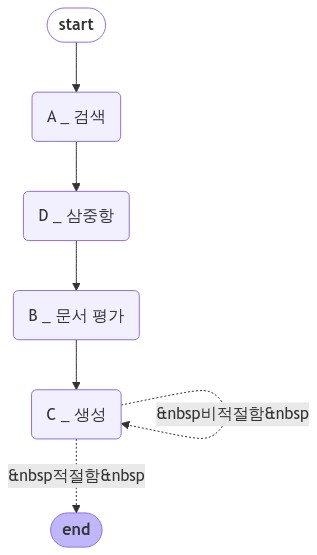

In [133]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

## .. 실행

In [88]:
# query = "사상 최고 해상도로 관측한 블랙홀의 이름은 무엇입니까?"
# query = "SK하이닉스가 최근 개발한 것은 무엇입니까?"

print(query)

# Run
inputs = {
    "question": query,
    # "documents": documents[2:5],
}

애플이 '카툭튀' 현상을 완화해주는 기술은 무엇인가요?


In [ ]:
import time

start_time = time.time()
node_time = start_time

for output in app.stream(inputs):
    for key, value in output.items():
        current_time = time.time()
        elapsed_time = current_time - node_time
        node_time = current_time
        print(f"노드 '{key}' 완료. ({elapsed_time:.3f}s)")
    print(f"\n{'=====' * 15}\n")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"{elapsed_time / 60:.3f} min")

In [307]:
print(f"{value['generation']}")

SK하이닉스는 '10나노급 6세대 D램' 세계 첫 개발을 통해 '11%· 전력효율 9%'의 기술을 세계 최초로 개발하였습니다.


In [134]:
print(f"{elapsed_time / 60:.3f} min")

8.035 min


# End